<a href="https://colab.research.google.com/github/dani-lbnl/2022_als_user_meeting/blob/main/03_voxeldistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALS User Meeting 2022
This notebook describes methods to extract key information from microCT image stacks
- Histograms
- Alternative interactive tools and hist
- Maximum intensity projection
- Largest connected component

Created by Dani Ushizima, CAMERA, LBNL - Aug 1st 2022


In [1]:
%matplotlib inline

In [8]:
import numpy as np
from scipy import ndimage as ndi
import fnmatch,os
import matplotlib.pyplot as plt
from glob import glob

from skimage import img_as_ubyte, filters, morphology, exposure, io
from skimage.filters import threshold_isodata
from skimage.transform import pyramid_expand
from skimage.measure import regionprops,label


# 1. Read a microct image
- from url
- from NERSC
- from Google drive

## Read from NERSC
- discard this portion if running in Colab

In [ ]:
datapath = "/global/cfs/cdirs/als/users/yourname/yourdata/" #update these values
!ls -lt "$datapath"

In [ ]:
image = io.imread(datapath+'bead_pack.tif')

## Read from Google drive 
- discard this portion if running at NERSC

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
datapath = "/content/drive/My Drive/Colab Notebooks/ALS User Meeting 2022 colab/data/"
!ls -lt "$datapath"

total 7842
-rw------- 1 root root 8025493 Aug 11 16:46 bead_pack.tif
drwx------ 2 root root    4096 Aug 11 16:35 concrete


In [9]:
def loadFileNames(path,extension):
  ''' Return filename after using colab files.upload - work for 1 file'''
  fnames = glob(path+extension)
  fnames.sort()
  print(path);
  print(f"Number of files: {len(fnames)}")
  return fnames

In [13]:
files = loadFileNames(datapath+'concrete/','*tif')

/content/drive/My Drive/Colab Notebooks/ALS User Meeting 2022 colab/data/concrete/
Number of files: 20


# 2. Image histograms
- histogram of a single slice
- histogram per slice for stack
- histogram of full stack 

In [14]:
len(files) #make sure nfile<len(files)

In [54]:
def seeHistSlice(aSlice):
        '''See the histogram of a particular slice after its masking, followed by enhancement'''
        hist, hist_centers = exposure.histogram(aSlice)
        fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

        ax[0].imshow(aSlice, cmap=plt.cm.gray, vmin=np.min(aSlice), vmax=np.max(aSlice))
        ax[0].set_title('One Slice')
        ax[0].axis('off')

        ax[1].plot(hist_centers, hist, lw=2)
        ax[1].set_title('Histogram of grey values')
        ax[1].grid()

        plt.tight_layout()

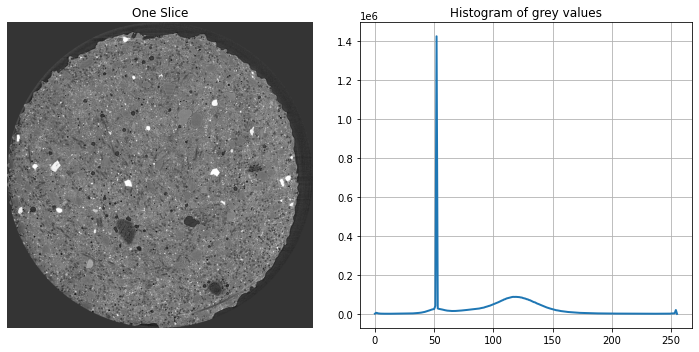

In [57]:
n = 5
aslice = io.imread(files[n])
seeHistSlice(aslice)

In [31]:
#Load full stack - if too large, you can modify functions below to read one slice at a time
ic = io.ImageCollection(files,conserve_memory=True)
fullstack = ic[0:10].concatenate()

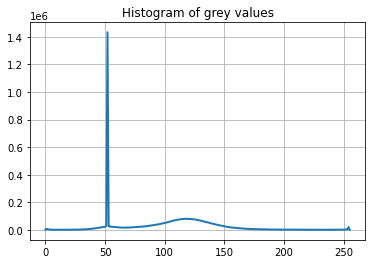

In [45]:
hist, hist_centers = exposure.histogram(fullstack)
plt.plot(hist_centers, hist, lw=2)
plt.title('Histogram for full stack')
plt.grid()

## What if visualizing hist per slice?

In [39]:
#Scroll through stack as with plotly, usually faster this way
from ipywidgets import interact,IntSlider

def slicer(z):
    plt.imshow(fullstack[z,:,:], cmap='hot')

In [35]:
maxz,_,_ = fullstack.shape
interact(slicer, z=IntSlider(min=0, max=maxz, step=1, value=maxz//2));

In [41]:
#Scroll through stack and visualize histogram
def seeHistSlice(img,nslice):
    subimage = img[nslice,:,:]
    hist = np.histogram(subimage, bins=np.arange(subimage.min(), subimage.max()))

    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    ax[0].imshow(subimage, interpolation='nearest', cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Slice #'+str(nslice))

    ax[1].plot(hist[1][:-1], hist[0], lw=1)
    ax[1].set_title('Histogram of gray values')
    ax[1].grid()
    plt.tight_layout()

def slicingHist(b):
    def slicer(z):
        seeHistSlice(b,z)
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));    

In [42]:
slicingHist(fullstack)

interactive(children=(IntSlider(value=5, description='z', max=9), Output()), _dom_classes=('widget-interact',)…

# 3. Maximum Intensity Projection (MIP)
[link paper](https://www.cambridge.org/core/journals/mrs-advances/article/abs/materials-data-science-for-microstructural-characterization-of-archaeological-concrete/AEB1323101655FEA3B166296F92708BC)

In [46]:
def maxProjection(stack,ndown):
        #max projection aka. z-max
        IM_MAX = stack[0,::ndown,::ndown]
        nslices,_,_ = stack.shape
        for n in np.arange(1,nslices,ndown): #ndown here for low variation on Z
            IM_MAX = np.maximum(IM_MAX, (stack[n,::ndown,::ndown]))
        return IM_MAX    

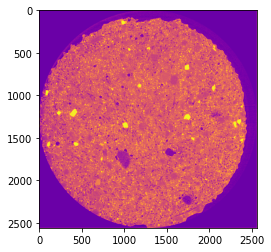

In [63]:
maxProjectionfullstack = maxProjection(fullstack,ndown=1)
plt.imshow(maxProjectionfullstack,cmap='plasma')

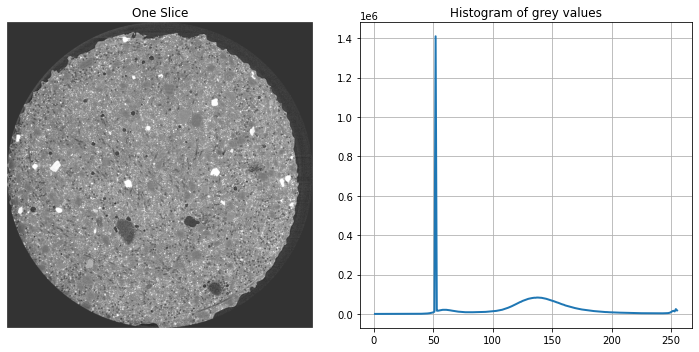

In [64]:
seeHistSlice(maxProjectionfullstack)

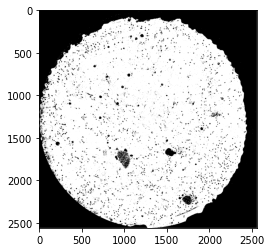

In [67]:
plt.imshow(maxProjectionfullstack>100,cmap='gray')

## Determine largest connected component
- if slices have common center, MIP can help determine ROI
- calculating a mask
- masking a slice

In [69]:
def getLargestCC(segments):
        '''Return the largest connected component from image'''
        labels = label(segments)
        largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segments.flat))
        return largestCC

In [73]:
lcc = getLargestCC(maxProjectionfullstack>100)

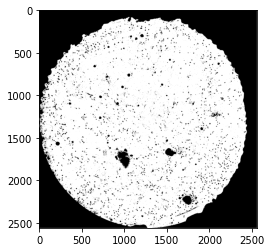

In [76]:
plt.imshow(lcc,cmap='gray')

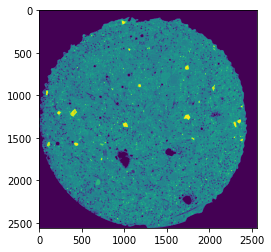

In [77]:
plt.imshow(aslice*lcc)
plt.title('Mask slice using MIP')